## Wordle

Basic EDA for a daily sample of Wordle results [tweets](https://www.kaggle.com/datasets/benhamner/wordle-tweets) from Wordle #210 (2022-01-16) to Wordle #303 (2022-04-19).

In [1]:
from IPython.display import Image

Image(url="image/wordle.png", width=300)
# can also insert as markdown: ![wordle](image/wordle.png)

In [11]:
import pandas as pd
from collections import Counter
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
import re

In [9]:
# for interactive popup figures
# import matplotlib
# matplotlib.use('TkAgg')
# import matplotlib.pyplot as plt

In [3]:
df_tweets = pd.read_csv('data/tweets.csv')
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457808 entries, 0 to 457807
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   wordle_id       457808 non-null  int64 
 1   tweet_id        457808 non-null  int64 
 2   tweet_date      457808 non-null  object
 3   tweet_username  457808 non-null  object
 4   tweet_text      457808 non-null  object
dtypes: int64(2), object(3)
memory usage: 17.5+ MB


In [47]:
df_tweets['tweet_date'] = pd.to_datetime(df_tweets['tweet_date'])
df_tweets['tweet_date_only'] = df_tweets['tweet_date'].dt.date
df_tweets['n_attempts'] = df_tweets['tweet_text'].str[11].astype('int')

# make each tweet consistent
df_tweets['tweet_text'] = df_tweets['tweet_text'].str.replace('⬜','⬛')
# parse each guess
for n in range(6):
    n += 1
    # figure out if it even has a guess
    df_tweets[f'has_guess{n}'] = \
        df_tweets['tweet_text'].str.split('\n') \
            .str[n + 1].str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)
    
    # Add the text if it's a guess
    df_tweets.loc[df_tweets[f'has_guess{n}'], f'guess{n}'] = \
        df_tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
    
    df_tweets.loc[df_tweets[f'has_guess{n}'],
               f'guess{n}_incorrect'] = df_tweets[f'guess{n}'].str.count('⬛')
    df_tweets.loc[df_tweets[f'has_guess{n}'],
               f'guess{n}_wrong_spot'] = df_tweets[f'guess{n}'].str.count('🟨')
    df_tweets.loc[df_tweets[f'has_guess{n}'],
               f'guess{n}_correct'] = df_tweets[f'guess{n}'].str.count('🟩')
    df_tweets.loc[df_tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n

In [48]:
df_tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_date_only,n_attempts,answer,day,has_guess1,...,has_guess5,guess5,guess5_incorrect,guess5_wrong_spot,guess5_correct,has_guess6,guess6,guess6_incorrect,guess6_wrong_spot,guess6_correct
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16,4,PANIC,Sunday,True,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬛⬛⬛⬛⬛\n🟩🟩🟨🟨⬛\n🟩🟩⬛🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16,4,PANIC,Sunday,True,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n⬛🟩⬛🟨⬛\n⬛🟩⬛🟨⬛\n🟩🟩🟩🟩🟩,2022-01-16,4,PANIC,Sunday,True,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟨🟨⬛⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16,3,PANIC,Sunday,True,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16,3,PANIC,Sunday,True,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


In [6]:
df_tweets.groupby("wordle_id")["wordle_id"].count()

wordle_id
210    2837
211    2894
212    2399
213    2119
214    2703
       ... 
299    3821
300    3369
301    3831
302    3698
303    3783
Name: wordle_id, Length: 92, dtype: int64

<AxesSubplot:title={'center':'Wordle Tweets by Day'}>

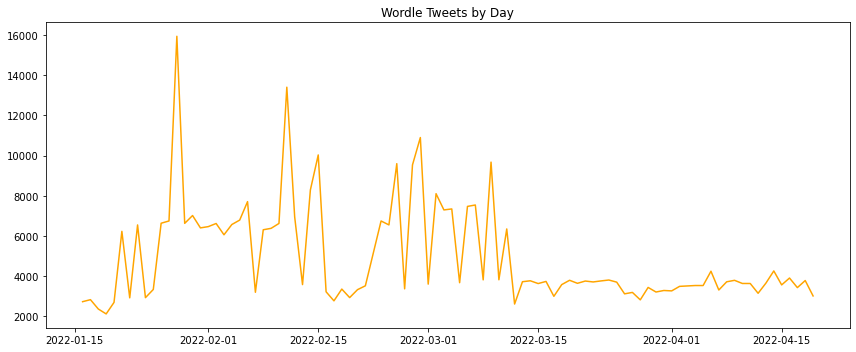

In [78]:
df_tweets['tweet_date_only'].value_counts().plot(figsize=(12, 5), title='Wordle Tweets by Day', color='orange')

In [42]:
df_tweets['day'] = df_tweets['tweet_date'].dt.day_name()
df_tweets.groupby(['tweet_date_only','day'])['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

,n_attempts,2,3,4,5,6
tweet_date_only,day,,,,,
2022-01-16,Sunday,214,863,1027,467,159
2022-01-17,Monday,194,879,998,549,210
2022-01-18,Tuesday,191,782,807,406,179
2022-01-19,Wednesday,53,272,641,683,472
2022-01-20,Thursday,378,1000,818,369,129
2022-01-21,Friday,490,1961,2114,1216,449
2022-01-22,Saturday,225,895,1007,592,202
2022-01-23,Sunday,277,1611,2451,1595,615
2022-01-24,Monday,38,343,927,1039,583


In [45]:
df_tweets.groupby('day')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
day,,,,,
Friday,4968,19506,28421,22193,11534
Monday,4127,16482,22699,16143,7458
Saturday,3761,12565,17245,13290,7124
Sunday,3959,16905,23852,14807,6022
Thursday,3925,14641,20257,14317,7084
Tuesday,4037,14144,18542,13372,6312
Wednesday,4573,16300,22669,16433,8141


In [26]:
map_dict = {
        '210' : 'PANIC',
        '211' : 'SOLAR',
        '212' : 'SHIRE',
        '213' : 'PROXY',
        '214' : 'POINT',
        '215' : 'ROBOT',
        '216' : 'PRICK',
        '217' : 'WINCE',
        '218' : 'CRIMP',
        '219' : 'KNOLL',
        '220' : 'SUGAR',
        '221' : 'WHACK',
        '222' : 'MOUNT',
        '223' : 'PERKY',
        '224' : 'COULD',
        '225' : 'WRUNG',
        '226' : 'LIGHT',
        '227' : 'THOSE',
        '228' : 'MOIST',
        '229' : 'SHARD',
        '230' : 'PLEAT',
        '231' : 'ALOFT',
        '232' : 'SKILL',
        '233' : 'ELDER',
        '234' : 'FRAME',
        '235' : 'HUMOR',
        '236' : 'PAUSE',
        '237' : 'ULCER',
        '238' : 'ULTRA',
        '239' : 'ROBIN',
        '240' : 'CYNIC',
        '241' : 'AROMA',
        '242' : 'CAULK',
        '243' : 'SHAKE',
        '244' : 'DODGE',
        '245' : 'SWILL',
        '246' : 'TACIT',
        '247' : 'OTHER',
        '248' : 'THORN',
        '249' : 'TROVE',
        '250' : 'BLOKE',
        '251' : 'VIVID',
        '252' : 'SPILL',
        '253' : 'CHANT',
        '254' : 'CHOKE',
        '255' : 'RUPEE',
        '256' : 'NASTY',
        '257' : 'MOURN',
        '258' : 'AHEAD',
        '259' : 'BRINE',
        '260' : 'CLOTH',
        '261' : 'HOARD',
        '262' : 'SWEET',
        '263' : 'MONTH',
        '264' : 'LAPSE',
        '265' : 'WATCH',
        '266' : 'TODAY',
        '267' : 'FOCUS',
        '268' : 'SMELT',
        '269' : 'TEASE',
        '270' : 'CATER',
        '271' : 'MOVIE',
        '272' : 'SAUTE',
        '273' : 'ALLOW',
        '274' : 'RENEW',
        '275' : 'THEIR',
        '276' : 'SLOSH',
        '277' : 'PURGE',
        '278' : 'CHEST',
        '279' : 'DEPOT',
        '280' : 'EPOXY',
        '281' : 'NYMPH',
        '282' : 'FOUND',
        '283' : 'SHALL',
        '284' : 'STOVE',
        '285' : 'LOWLY',
        '286' : 'SNOUT',
        '287' : 'TROPE',
        '288' : 'FEWER',
        '289' : 'SHAWL',
        '290' : 'NATAL',
        '291' : 'COMMA',
        '292' : 'FORAY',
        '293' : 'SCARE',
        '294' : 'STAIR',
        '295' : 'BLACK',
        '296' : 'SQUAD',
        '297' : 'ROYAL',
        '298' : 'CHUNK',
        '299' : 'MINCE',
        '300' : 'SHAME',
        '301' : 'CHEEK',
        '302' : 'AMPLE'}

In [41]:
map_dict = {int(k):str(v) for k,v in map_dict.items()}

df_tweets['answer'] = df_tweets['wordle_id'].map(map_dict)
df_tweets.groupby('answer')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)


n_attempts,2,3,4,5,6
answer,,,,,
AHEAD,309,1488,2592,1999,901
ALLOW,144,743,1216,973,568
ALOFT,360,1836,2832,1974,811
AMPLE,173,788,1309,1028,400
AROMA,353,1791,2386,1572,733
BLACK,395,1179,1299,661,245
BLOKE,476,1603,2419,1782,826
BRINE,341,995,1192,734,382
CATER,257,723,813,657,547


<AxesSubplot:title={'center':'Number of Attempts'}>

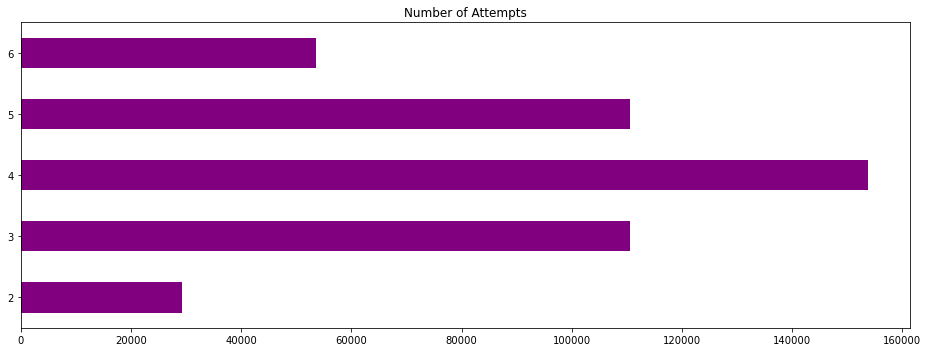

In [77]:
df_tweets['n_attempts'].value_counts().sort_index().plot(kind='barh', title='Number of Attempts', color='purple')

<AxesSubplot:title={'center':'Most Common Correct Guessed Letters on First Try'}>

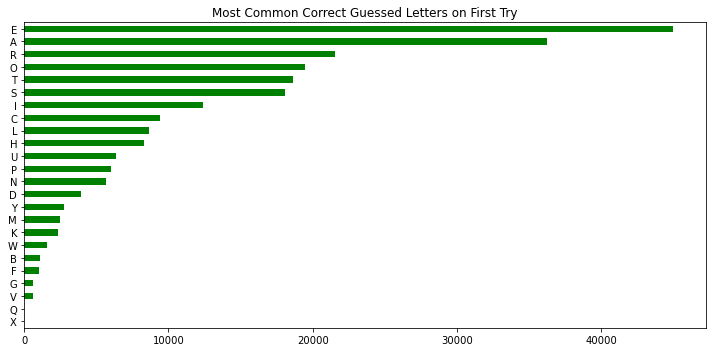

In [80]:
# count the correctly guessed first letters
first_guess_correct = []
for i, d in df_tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5), color='green',
          title='Most Common Correct Guessed Letters on First Try')

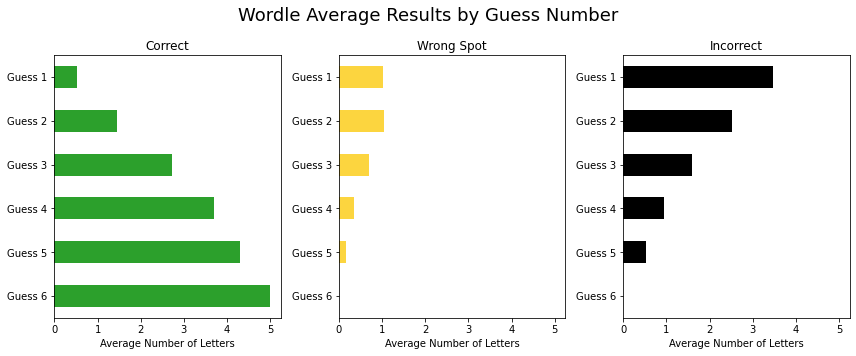

In [62]:
color_pal = ['#2ca02c', '#fcd53f', '#000000']

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in df_tweets.columns if x in c]
    guess_avg = df_tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False).plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i], color=color_pal[i])
    axs[i].set_xlabel('Average Number of Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

In [63]:
guess1_split = df_tweets.set_index('tweet_id') \
    ['guess1'].str.split('', expand=True) \
    .drop([0, 6], axis=1)

guess1_split = guess1_split.unstack().reset_index() \
    .rename(columns={'level_0':'letter_loc',
                     0:'result'})

guess1_split.groupby('letter_loc')['result'] \
    .value_counts().unstack().T \
    .style.background_gradient()

letter_loc,1,2,3,4,5
result,,,,,
⬛,334465,304259,310049,320553,316362
🟨,79619,105911,98156,99816,85048
🟩,43724,47638,49603,37439,56398


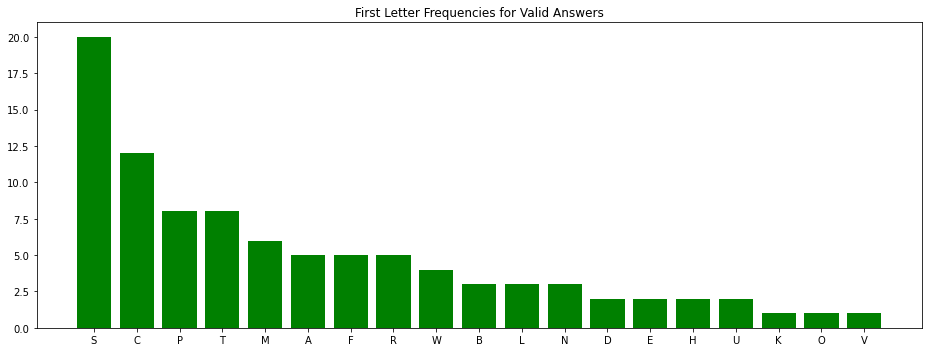

In [76]:
word_list = [*map_dict.values()]
unique_word_list = np.unique(word_list)

first_letter_list = [word[0] for word in list(unique_word_list)]
count = Counter(first_letter_list)

plt.rc("figure", autolayout=True, figsize=(13, 5))
ax = plt.bar(*zip(*count.most_common()), color='green')
plt.title("First Letter Frequencies for Valid Answers");